In [17]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.lines
import matplotlib as mpl
import sklearn.manifold
import sklearn.decomposition
import sklearn.cluster
import sklearn.svm
import h5py
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
from matplotlib import cm
import pandas as pd
import medutils
import torch

## ADNI

In [32]:
ckpt_path = '../ADNI/ckpt/ADNI/'
phase = 'test'
week = 18
task = 'pretext'
model = 'VN_Net'
#model_label = 'VN_Net/VN_Net_single_loss'  # ls=1024, bs=64
#model_label = 'VN_Net/VN_Net_updated_loss'  # ls=1024, bs=64
#model_label = 'VN_Net/VN_Net_extra_term'  # ls=1024, bs=64
#model_label = 'VN_Net/VN_Net_all_axes'  # ls=1024, bs=64

model_label = 'VN_Net_best_results_prev'  # ls=1024, bs=64
#model_label = 'VN_Net_fold_0_fixed_massive_normalized'
trained_data = h5py.File(ckpt_path+f'{model}/week{week}/{task}/{model_label}/result_{phase}/results_all.h5', 'r')
#untrained_data = h5py.File(ckpt_path+model_label+f'/result_{phase}/results_all_no_training.h5', 'r')

Setup Data

In [33]:
img1 = trained_data['img1']
img2 = trained_data['img2']
label = trained_data['label']
rot = trained_data['rot']
axis = trained_data['axis']
z1 = trained_data['z1']
z2 = trained_data['z2']
z1_rot = trained_data['z1_matmul']
z2_rot = trained_data['z2_matmul']

In [34]:
sample_size = 64

random_sample = np.sort(np.random.choice(len(img1), sample_size, replace=False))
# sort
print(random_sample)
selected_img1 = img1[random_sample]
selected_img2 = img2[random_sample]
selected_labels = label[random_sample]
selected_rot = rot[random_sample]
selected_axis = axis[random_sample]
selected_z1 = z1[random_sample]
selected_z2 = z2[random_sample]
selected_z1_rot = z1_rot[random_sample]
selected_z2_rot = z2_rot[random_sample]

[  1  14  18  57  92  97  98 102 109 111 114 128 132 138 147 171 172 186
 187 204 206 233 243 246 275 277 283 284 316 321 325 330 335 344 357 358
 379 389 397 401 405 420 436 439 449 451 454 479 481 486 487 488 490 495
 502 511 513 524 537 552 558 563 570 572]


In [5]:
untrained_img1 = untrained_data['img1']
untrained_img2 = untrained_data['img2']
untrained_rot = untrained_data['rot']
untrained_axis = untrained_data['axis']
untrained_z1 = untrained_data['z1']
untrained_z2 = untrained_data['z2']
untrained_z1_rot = untrained_data['z1_matmul']
untrained_z2_rot = untrained_data['z2_matmul']

selected_untrained_img1 = untrained_img1[random_sample]
selected_untrained_img2 = untrained_img2[random_sample]
selected_untrained_rot = untrained_rot[random_sample]
selected_untrained_axis = untrained_axis[random_sample]
selected_untrained_z1 = untrained_z1[random_sample]
selected_untrained_z2 = untrained_z2[random_sample]
selected_untrained_z1_rot = untrained_z1_rot[random_sample]
selected_untrained_z2_rot = untrained_z2_rot[random_sample]

In [ ]:
condition_img1 = (selected_untrained_img1 == selected_img1).all()
condition_img2 = (selected_untrained_img2 == selected_img2).all()
condition_rot = (selected_untrained_rot == selected_rot).all()
condition_axis = (selected_untrained_axis == selected_axis).all()
condition_z1 = (selected_untrained_z1 != selected_z1).all()
condition_z2 = (selected_untrained_z2 != selected_z2).all()
print("Sanity check for matching data:")
assert all([
    condition_img1, 
    condition_img2,
    condition_rot,
    condition_axis,
    condition_z1,
    condition_z2
])

In [28]:
selected_z1.shape

(64, 1024, 3)

In [35]:
print(f'std: {np.std(selected_z1)}')
print(f'std: {np.std(selected_z2)}')


std: 0.2355795055627823
std: 0.24658343195915222


In [36]:
print(f'std: {np.std(selected_z1[0])}')
print(f'std: {np.std(selected_z2[0])}')

std: 0.23799975216388702
std: 0.2456454038619995


Distance Metrics

In [ ]:
print("Distance metrics/sample before training:")
diff_matrix_1 = torch.tensor(selected_untrained_z2 - selected_untrained_z1_rot)
diff_matrix_2 = torch.tensor(selected_untrained_z1 - selected_untrained_z2_rot)
distance_loss = torch.norm(diff_matrix_1, p='fro', dim=(1, 2)) + torch.norm(diff_matrix_2, p='fro', dim=(1, 2))
#distance_loss = torch.norm(diff_matrix_1, p='fro', dim=(1, 2))
mean_frobenius_norm = torch.mean(distance_loss)
print(f"Distance loss: {mean_frobenius_norm}")

diff_matrix_3 = torch.tensor(selected_untrained_z1 - selected_untrained_z2)
maximize_loss = torch.norm(diff_matrix_3, p='fro', dim=(1, 2))  # negative sign to maximize the distance
max_frobenius_norm = torch.mean(maximize_loss)
print(f"Distance loss z1/z2 to be maximized: {max_frobenius_norm}")

In [7]:
print("Distance metrics/sample after training:")
diff_matrix_1 = torch.tensor(selected_z2 - selected_z1_rot)
diff_matrix_2 = torch.tensor(selected_z1 - selected_z2_rot)
distance_loss = torch.norm(diff_matrix_1, p='fro', dim=(1, 2)) + torch.norm(diff_matrix_2, p='fro', dim=(1, 2))
#distance_loss = torch.norm(diff_matrix_1, p='fro', dim=(1, 2))
mean_frobenius_norm = torch.mean(distance_loss)
print(f"Distance loss: {mean_frobenius_norm}")

diff_matrix_3 = torch.tensor(selected_z1 - selected_z2)
maximize_loss = torch.norm(diff_matrix_3, p='fro', dim=(1, 2))  # negative sign to maximize the distance
max_frobenius_norm = torch.mean(maximize_loss)
print(f"Distance loss z1/z2 to be maximized: {max_frobenius_norm}")

Distance metrics/sample after training:
Distance loss: 2.6951878680847585e-05
Distance loss z1/z2 to be maximized: 0.0


Raw vectors

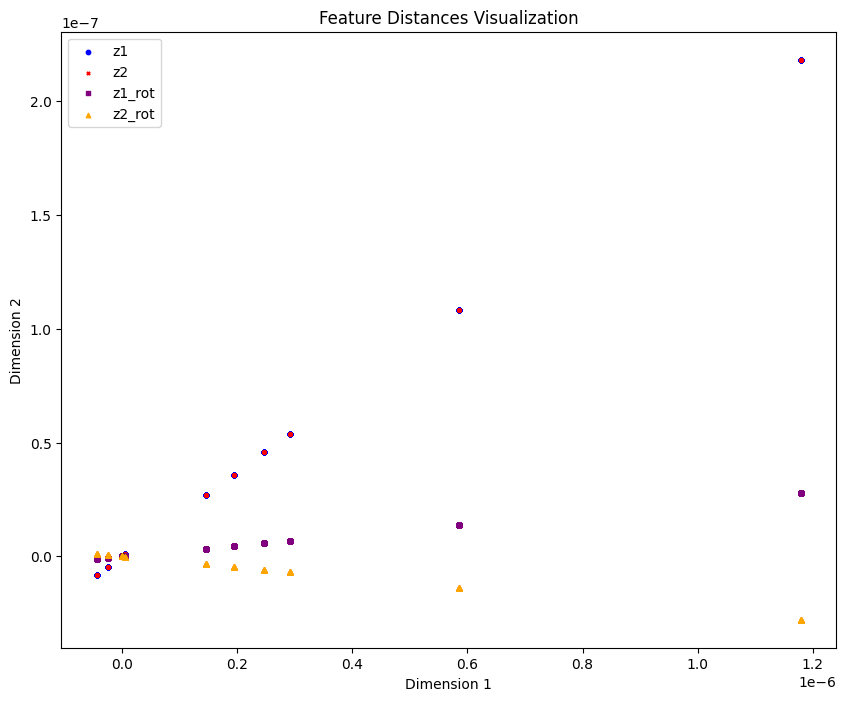

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(selected_z1[0][:, 0], selected_z1[0][:, 1], label='z1', marker='o', color='blue', s=10)
plt.scatter(selected_z2[0][:, 0], selected_z2[0][:, 1], label='z2', marker='x', color='red', s=5)
plt.scatter(selected_z1_rot[0][:, 0], selected_z1_rot[0][:, 1], label='z1_rot', marker='s', color='purple', s=10)
plt.scatter(selected_z2_rot[0][:, 0], selected_z2_rot[0][:, 1], label='z2_rot', marker='^', color='orange', s=10)
#plt.scatter(selected_untrained_z1[0][:, 0], selected_untrained_z1[0][:, 1], label='untrained_z1', marker='x', color='yellow', s=5)
#plt.scatter(selected_untrained_z1_rot[0][:, 0], selected_untrained_z1_rot[0][:, 1], label='untrained_z1_rot', marker='x', color='green', s=5)
#plt.scatter(selected_untrained_z2_rot[0][:, 0], selected_untrained_z2_rot[0][:, 1], label='untrained_z2_rot', marker='x', color='brown', s=5)

# we see the decreased distance

plt.legend()
plt.title("Feature Distances Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.show()

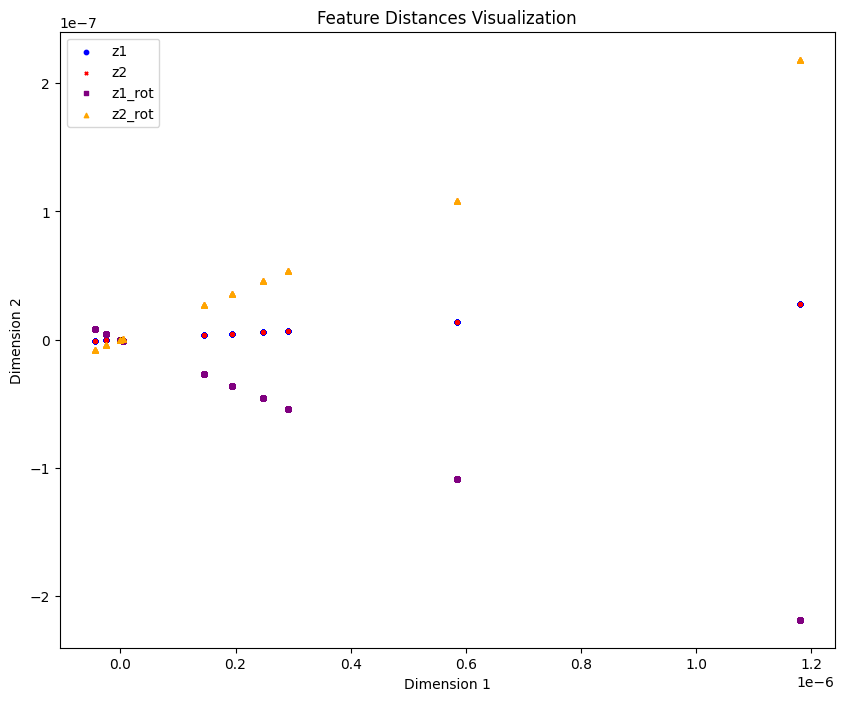

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(selected_z1[0][:, 0], selected_z1[0][:, 2], label='z1', marker='o', color='blue', s=10)
plt.scatter(selected_z2[0][:, 0], selected_z2[0][:, 2], label='z2', marker='x', color='red', s=5)
plt.scatter(selected_z1_rot[0][:, 0], selected_z1_rot[0][:, 2], label='z1_rot', marker='s', color='purple', s=10)
plt.scatter(selected_z2_rot[0][:, 0], selected_z2_rot[0][:, 2], label='z2_rot', marker='^', color='orange', s=10)
#plt.scatter(selected_untrained_z1[0][:, 0], selected_untrained_z1[0][:, 2], label='untrained_z1', marker='x', color='yellow', s=5)
#plt.scatter(selected_untrained_z1_rot[0][:, 0], selected_untrained_z1_rot[0][:, 2], label='untrained_z1_rot', marker='x', color='green', s=5)
#plt.scatter(selected_untrained_z2_rot[0][:, 0], selected_untrained_z2_rot[0][:, 2], label='untrained_z2_rot', marker='x', color='brown', s=5)


plt.legend()
plt.title("Feature Distances Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(selected_z1[0][:, 1], selected_z1[0][:, 2], label='z1', marker='o', color='blue', s=10)
plt.scatter(selected_z2[0][:, 1], selected_z2[0][:, 2], label='z2', marker='x', color='red', s=5)
#plt.scatter(selected_z1_rot[0][:, 1], selected_z1_rot[0][:, 2], label='z1_rot', marker='s', color='purple', s=10)
plt.scatter(selected_z2_rot[0][:, 1], selected_z2_rot[0][:, 2], label='z2_rot', marker='^', color='orange', s=10)
plt.scatter(selected_untrained_z1[0][:, 1], selected_untrained_z1[0][:, 2], label='untrained_z1', marker='x', color='yellow', s=5)
#plt.scatter(selected_untrained_z1_rot[0][:, 1], selected_untrained_z1_rot[0][:, 2], label='untrained_z1_rot', marker='x', color='green', s=5)
plt.scatter(selected_untrained_z2_rot[0][:, 1], selected_untrained_z2_rot[0][:, 2], label='untrained_z2_rot', marker='x', color='brown', s=5)


plt.legend()
plt.title("Feature Distances Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.show()

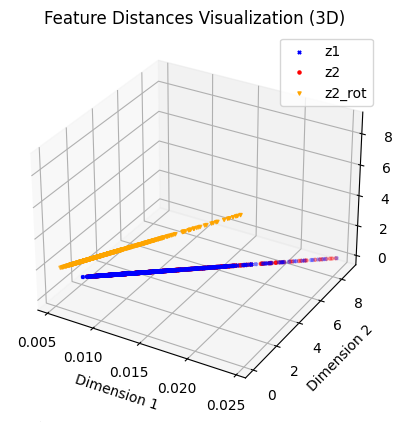

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(selected_z1[0][:, 0], selected_z1[0][:, 1], selected_z1[0][:, 2], label='z1', marker='x', color='blue', s=5)
ax.scatter(selected_z2[0][:, 0], selected_z2[0][:, 1], selected_z2[0][:, 2], label='z2', marker='o', color='red', s=5)
ax.scatter(selected_z2_rot[0][:, 0], selected_z2_rot[0][:, 1], selected_z2_rot[0][:, 2], label='z2_rot', marker='v', color='orange', s=5)
ax.scatter(selected_untrained_z2_rot[0][:, 0], selected_untrained_z2_rot[0][:, 1], selected_untrained_z2_rot[0][:, 2], label='untrained_z2_rot', marker='v', color='yellow', s=5)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.legend()
plt.title("Feature Distances Visualization (3D)")
plt.show()

### Visualize each sample as a point in 2D space

Only take NC samples from trained evaluation into consideration

Do analysis for a single rot and axis combination, to avoid clustering by rot angle or axis

If I don't do single axis combination, i will see three clusters, each for the three axes

In [5]:
labels = trained_data['label'][:]
rot = trained_data['rot'][:]
axis = trained_data['axis'][:]

label_class = 0
angle = 90
filter_axis = [0, 1, 0]

# Define filter conditions
label_condition = (labels == label_class)
angle_condition = (rot == angle)
axis_condition = np.all(axis == filter_axis, axis=1)  # Assuming 'axis' is a 2D array

mask = label_condition & angle_condition & axis_condition

# Combine the conditions using logical AND
nc_img1 = img1[mask]
nc_img2 = img2[mask]
nc_rot = rot[mask]
nc_axis = axis[mask]
nc_z1 = z1[mask]
nc_z2 = z2[mask]
nc_z1_rot = z1_rot[mask]
nc_z2_rot = z2_rot[mask]

In [6]:
sample_size = min(len(nc_img1), 64)
print(f"Number of samples: {len(nc_img1)}")
random_sample = np.sort(np.random.choice(len(nc_img1), sample_size, replace=False))
# sort
print(random_sample)
nc_selected_img1 = nc_img1[random_sample]
nc_selected_img2 = nc_img2[random_sample]
nc_selected_rot = nc_rot[random_sample]
nc_selected_axis = nc_axis[random_sample]
nc_selected_z1 = nc_z1[random_sample]
nc_selected_z2 = nc_z2[random_sample]
nc_selected_z1_rot = nc_z1_rot[random_sample]
nc_selected_z2_rot = nc_z2_rot[random_sample]

Number of samples: 16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [7]:
print("Distance metrics/sample after training:")
diff_matrix_1 = torch.tensor(nc_selected_z2 - nc_selected_z1_rot)
diff_matrix_2 = torch.tensor(nc_selected_z1 - nc_selected_z2_rot)
distance_loss = torch.norm(diff_matrix_1, p='fro', dim=(1, 2)) + torch.norm(diff_matrix_2, p='fro', dim=(1, 2))
mean_frobenius_norm = torch.mean(distance_loss)
print(f"Distance loss: {mean_frobenius_norm}")

diff_matrix_3 = torch.tensor(nc_selected_z1 - nc_selected_z2)
maximize_loss = torch.norm(diff_matrix_3, p='fro', dim=(1, 2))  # negative sign to maximize the distance
max_frobenius_norm = torch.mean(maximize_loss)
print(f"Distance loss z1/z2 to be maximized: {max_frobenius_norm}")

print(f"Distance loss combined: {mean_frobenius_norm - 0.25*max_frobenius_norm}")

Distance metrics/sample after training:
Distance loss: 3.1533014407614246e-05
Distance loss z1/z2 to be maximized: 0.0
Distance loss combined: 3.1533014407614246e-05


img2 = R x img1
z2 = f(img2)
z1 = f(img1)

z1_rot = R x f(img1)
d1 = |z1_rot - z2|
d1 -> 0

z2_rot = R.t x f(img2)
d2 = |z2_rot - z1|
d2 -> 0

d3 = |z1 - z2|
d3 -> 0

d1 ~= d2 ~= d3

hypothesis: img2 and img1 are very similar semantically
not sure that maximizing that is the solution, seems counter intuitive, we're changing z2 rot with that

take two brains of different people of the same class, img2 is a rotation of a different brain, which might make the training task more difficult for the model -> increase variations
-> want model to pay attention to overall structure, such as shape, and not details
-> force it to look at the actual rotation, rather than the details

In [7]:
nc_selected_z1.shape

(16, 1024, 3)

In [9]:
# reshape each fs from (1024, 3) to (3*1024,)
nc_selected_z1 = nc_selected_z1.reshape(sample_size, -1)
nc_selected_z2 = nc_selected_z2.reshape(sample_size, -1)
nc_selected_z1_rot = nc_selected_z1_rot.reshape(sample_size, -1)
nc_selected_z2_rot = nc_selected_z2_rot.reshape(sample_size, -1)

In [9]:
# to visualize the feature space, we need to reduce the dimensionality using PCA and/or t-SNE
# first, let's try t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=min(30, sample_size-1), random_state=0)
# what if all data is not fit in at the same time, all four feature spaces are fit in at the same time!!!

nc_z1_embedded = tsne.fit_transform(nc_selected_z1)
nc_z2_embedded = tsne.fit_transform(nc_selected_z2)
nc_z1_rot_embedded = tsne.fit_transform(nc_selected_z1_rot)
nc_z2_rot_embedded = tsne.fit_transform(nc_selected_z2_rot)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(nc_z1_embedded[:, 0], nc_z1_embedded[:, 1], label='z1', marker='o', color='blue', s=5)
plt.scatter(nc_z2_embedded[:, 0], nc_z2_embedded[:, 1], label='z2', marker='o', color='red', s=5)
plt.scatter(nc_z1_rot_embedded[:, 0], nc_z1_rot_embedded[:, 1], label='z1_rot', marker='o', color='green', s=5)
plt.scatter(nc_z2_rot_embedded[:, 0], nc_z2_rot_embedded[:, 1], label='z2_rot', marker='o', color='purple', s=5)

plt.legend()
plt.title("Feature Distances Visualization")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")

plt.show()

: 

In [21]:
# Combine all feature vectors into one matrix along the first dimension
#combined_features = np.vstack((nc_selected_z1, nc_selected_z2, nc_selected_z1_rot, nc_selected_z2_rot))

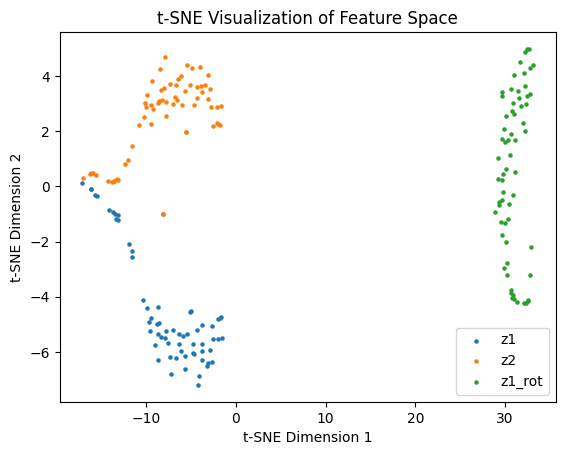

In [29]:
# Initialize t-SNE
combined_features = np.concatenate([nc_selected_z1, nc_selected_z2, nc_selected_z1_rot], 0)

tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=0)

embedded_data = tsne.fit_transform(combined_features)

# Separate the embedded data into four different variables
nc_embedded_z1 = embedded_data[:sample_size, :]
nc_embedded_z2 = embedded_data[sample_size:2*sample_size, :]
nc_embedded_z1_rot = embedded_data[2*sample_size:, :]

# Now, you can create scatter plots to visualize each set of embedded data in different colors
plt.scatter(nc_embedded_z1[:, 0], nc_embedded_z1[:, 1], label='z1', s=5)
plt.scatter(nc_embedded_z2[:, 0], nc_embedded_z2[:, 1], label='z2', s=5)
plt.scatter(nc_embedded_z1_rot[:, 0], nc_embedded_z1_rot[:, 1], label='z1_rot', s=5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Feature Space')
plt.legend()
plt.show()

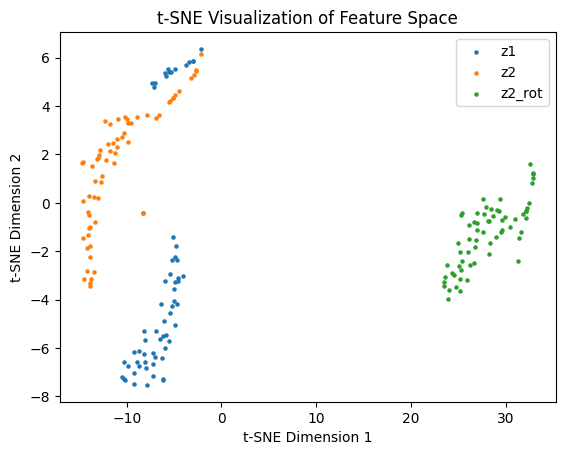

In [30]:
combined_features = np.concatenate([nc_selected_z1, nc_selected_z2, nc_selected_z2_rot], 0)

# Initialize t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=0)

embedded_data = tsne.fit_transform(combined_features)

# Separate the embedded data into four different variables
nc_embedded_z1 = embedded_data[:sample_size, :]
nc_embedded_z2 = embedded_data[sample_size:2*sample_size, :]
nc_embedded_z2_rot = embedded_data[2*sample_size:, :]

# Now, you can create scatter plots to visualize each set of embedded data in different colors
plt.scatter(nc_embedded_z1[:, 0], nc_embedded_z1[:, 1], label='z1', s=5)
plt.scatter(nc_embedded_z2[:, 0], nc_embedded_z2[:, 1], label='z2', s=5)
plt.scatter(nc_embedded_z2_rot[:, 0], nc_embedded_z2_rot[:, 1], label='z2_rot', s=5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Feature Space')
plt.legend()
plt.show()

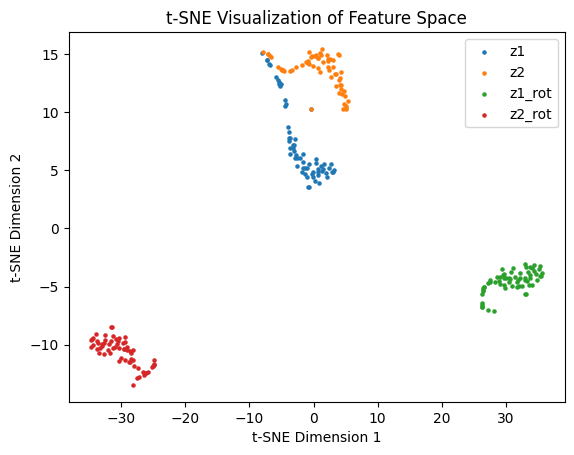

In [31]:
combined_features = np.concatenate([nc_selected_z1, nc_selected_z2, nc_selected_z1_rot, nc_selected_z2_rot], 0)

# Initialize t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=0)

embedded_data = tsne.fit_transform(combined_features)

# Separate the embedded data into four different variables
nc_embedded_z1 = embedded_data[:sample_size, :]
nc_embedded_z2 = embedded_data[sample_size:2*sample_size, :]
nc_embedded_z1_rot = embedded_data[2*sample_size:3*sample_size, :]
nc_embedded_z2_rot = embedded_data[3*sample_size:, :]

# Now, you can create scatter plots to visualize each set of embedded data in different colors
plt.scatter(nc_embedded_z1[:, 0], nc_embedded_z1[:, 1], label='z1', s=5)
plt.scatter(nc_embedded_z2[:, 0], nc_embedded_z2[:, 1], label='z2', s=5)
plt.scatter(nc_embedded_z1_rot[:, 0], nc_embedded_z1_rot[:, 1], label='z1_rot', s=5)
plt.scatter(nc_embedded_z2_rot[:, 0], nc_embedded_z2_rot[:, 1], label='z2_rot', s=5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Feature Space')
plt.legend()
plt.show()

PCA

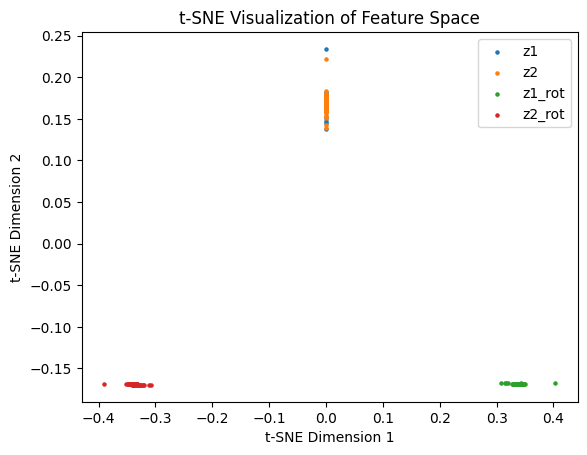

In [32]:
# Initialize PCA
pca = sklearn.decomposition.PCA(n_components=2)

embedded_data = pca.fit_transform(combined_features)

# Separate the embedded data into four different variables
nc_embedded_z1 = embedded_data[:sample_size, :]
nc_embedded_z2 = embedded_data[sample_size:2*sample_size, :]
nc_embedded_z1_rot = embedded_data[2*sample_size:3*sample_size, :]
nc_embedded_z2_rot = embedded_data[3*sample_size:, :]

# Now, you can create scatter plots to visualize each set of embedded data in different colors
plt.scatter(nc_embedded_z1[:, 0], nc_embedded_z1[:, 1], label='z1', s=5)
plt.scatter(nc_embedded_z2[:, 0], nc_embedded_z2[:, 1], label='z2', s=5)
plt.scatter(nc_embedded_z1_rot[:, 0], nc_embedded_z1_rot[:, 1], label='z1_rot', s=5)
plt.scatter(nc_embedded_z2_rot[:, 0], nc_embedded_z2_rot[:, 1], label='z2_rot', s=5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Feature Space')
plt.legend()
plt.show()

Original sample
Rotated sample


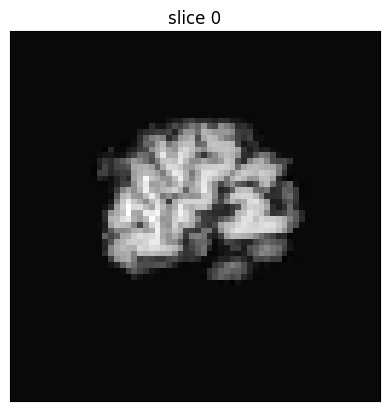

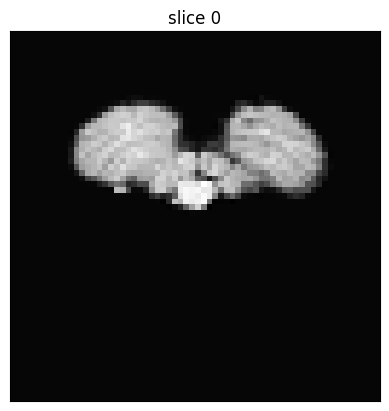

In [33]:
# visualization sanity check
print("Original sample")
medutils.visualization.show(nc_img1[0][0][5])
print("Rotated sample")
medutils.visualization.show(nc_img2[0][0][5])